In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

# 항공사 고객 만족도 예측 경진대회 [Dacon Basic]

## 데이터 불러오기

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('./train.csv')
data = data.drop('id', axis=1) # id 제외하고 분석

test = pd.read_csv('./test.csv')
test = test.drop('id', axis=1) # id 제외하고 분석

pd.set_option('display.max_columns', None) # 컬럼 수가 많으므로 요약되어 표시되지 않게 함
data # 데이터 확인

FileNotFoundError: [Errno 2] No such file or directory: './train.csv'

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             3000 non-null   object 
 1   Customer Type                      3000 non-null   object 
 2   Age                                3000 non-null   int64  
 3   Type of Travel                     3000 non-null   object 
 4   Class                              3000 non-null   object 
 5   Flight Distance                    3000 non-null   int64  
 6   Seat comfort                       3000 non-null   int64  
 7   Departure/Arrival time convenient  3000 non-null   int64  
 8   Food and drink                     3000 non-null   int64  
 9   Gate location                      3000 non-null   int64  
 10  Inflight wifi service              3000 non-null   int64  
 11  Inflight entertainment             3000 non-null   int64

Gender, Customer Type, Type of Travel, Class는 범주형 데이터  
Age, Flight Distance, Departure Delay in Minutes, Arrival Delay in Minutes를 제외한 feature들은 0~5 사이의 degree값을 나타내는 정수형임을 확인했습니다.

In [ ]:
data.isna().sum()

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Seat comfort                         0
Departure/Arrival time convenient    0
Food and drink                       0
Gate location                        0
Inflight wifi service                0
Inflight entertainment               0
Online support                       0
Ease of Online booking               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Cleanliness                          0
Online boarding                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
target                               0
dtype: int64

결측치 확인결과 결측치가 존재하지 않습니다.

## 기초 통계 분석

### feature 분포 시각화

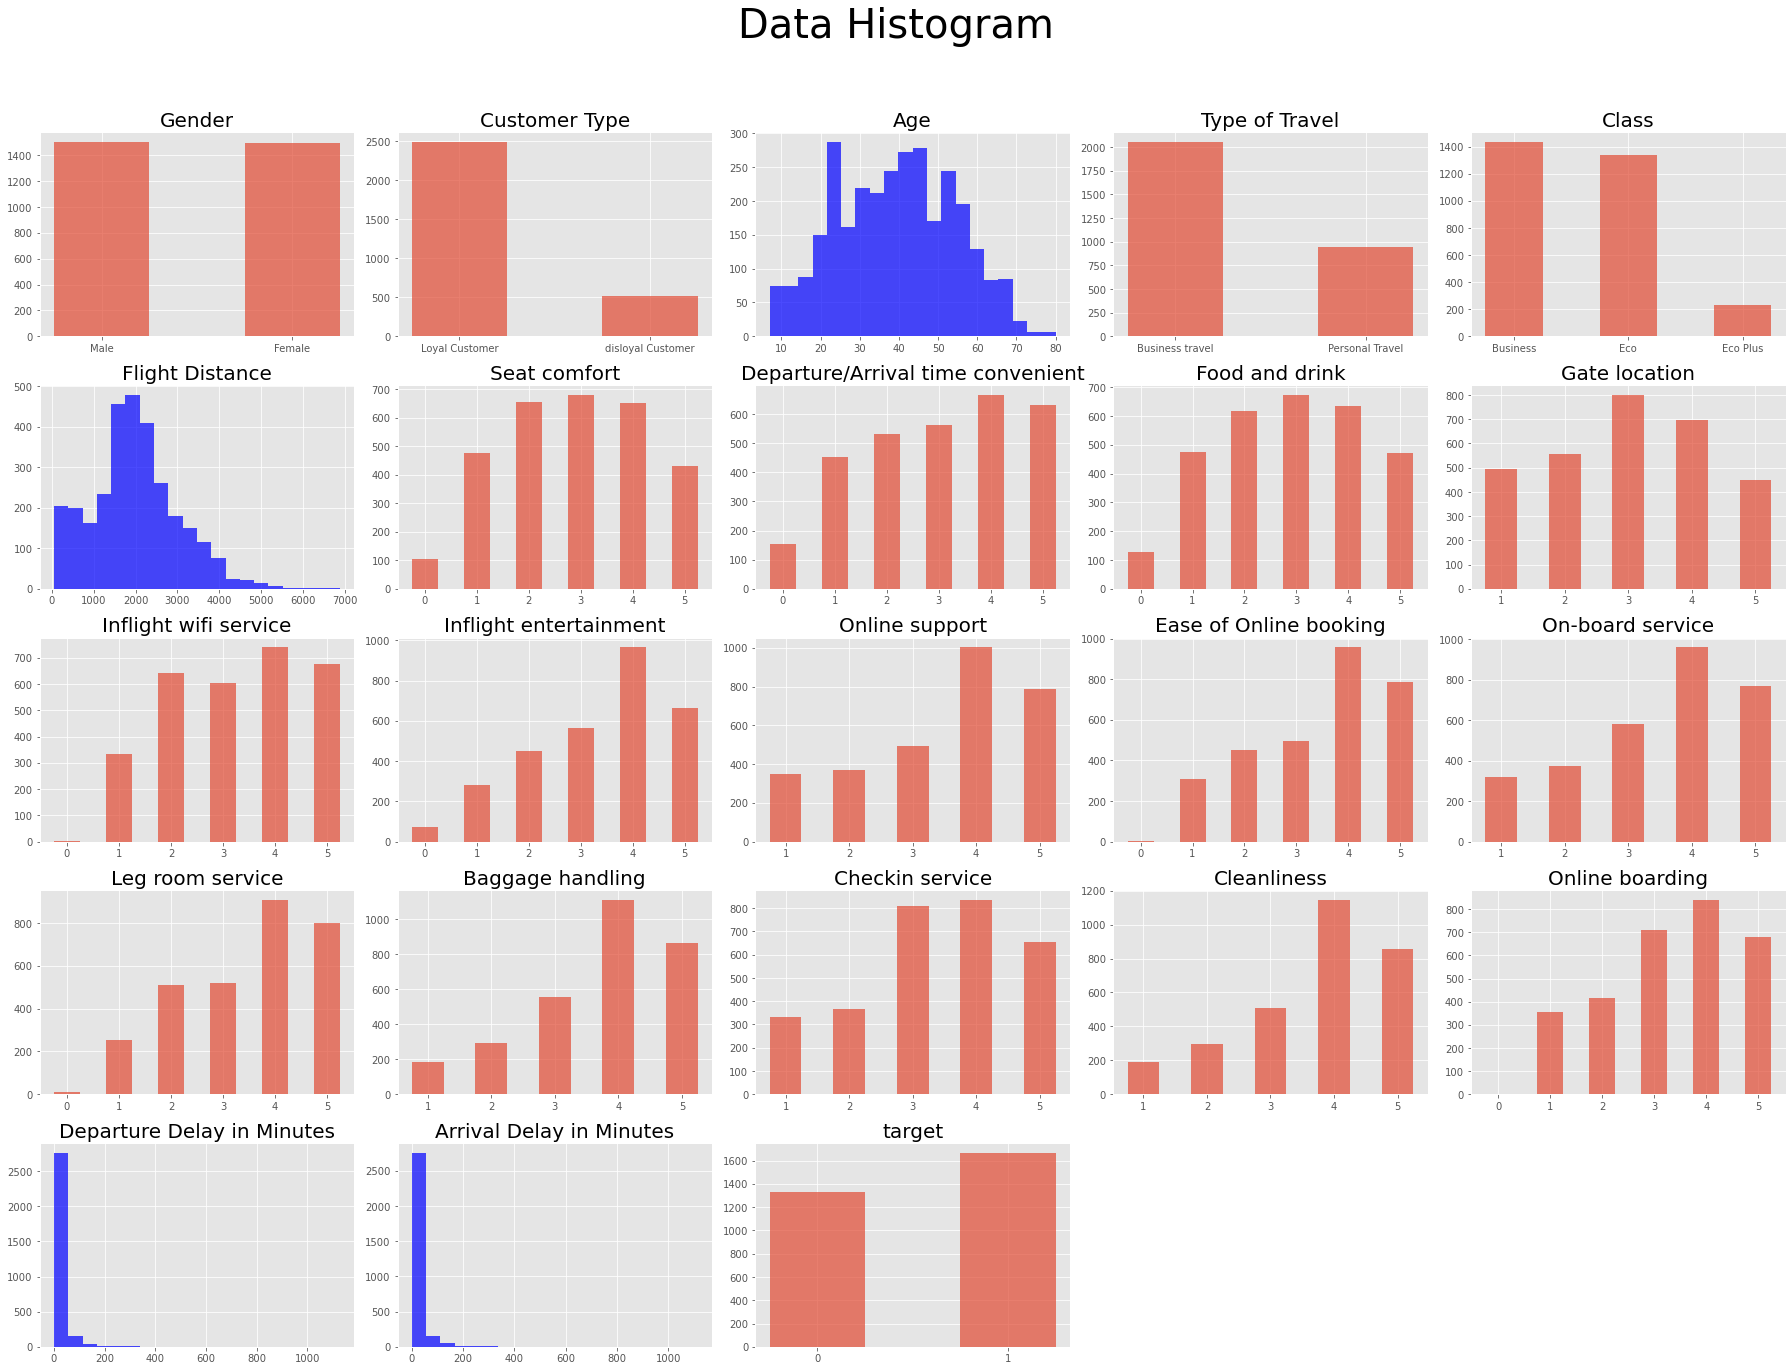

In [ ]:
plt.style.use('ggplot')

# 히스토그램을 사용해서 데이터의 분포 살펴보기
plt.figure(figsize=(25, 20))
plt.suptitle("Data Histogram", fontsize = 40)

# id는 제외하고 시각화
cols = data.columns
for i in range(len(cols)):
    plt.subplot(5, 5, i+1) # 최대 5 by 5, 25개의 특징 분포를 확인할 수 있습니다.
    plt.title(cols[i], fontsize=20) # 각 분포그림의 제목을 특징명으로 설정합니다.
    if len(data[cols[i]].unique()) > 20: # 해당 특징의 고유한 값 종류가 20개가 넘으면
        plt.hist(data[cols[i]], bins=20, color='b', alpha=0.7) # 히스토그램을 출력합니다. bins는 칸을 나누는 값이며 alpha는 투명도입니다.
        
    else: # 해당 특징의 고유한 값 종류가 20개가 넘지 않으면
        temp = data[cols[i]].value_counts() # 각 특징의 값 종류의 개수들을 temp에 저장합니다.
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
        
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

파란 그래프가 아닌 것은 2개 혹은 5개의 값으로 이루어져 있으며  
파란 그래프는 연속된 값들 입니다. 파란색 그래프만 보면 age를 제외하고 왼쪽으로 치우쳐져 있는 것을 볼 수 있습니다.

## target과 feature들의 관계 확인

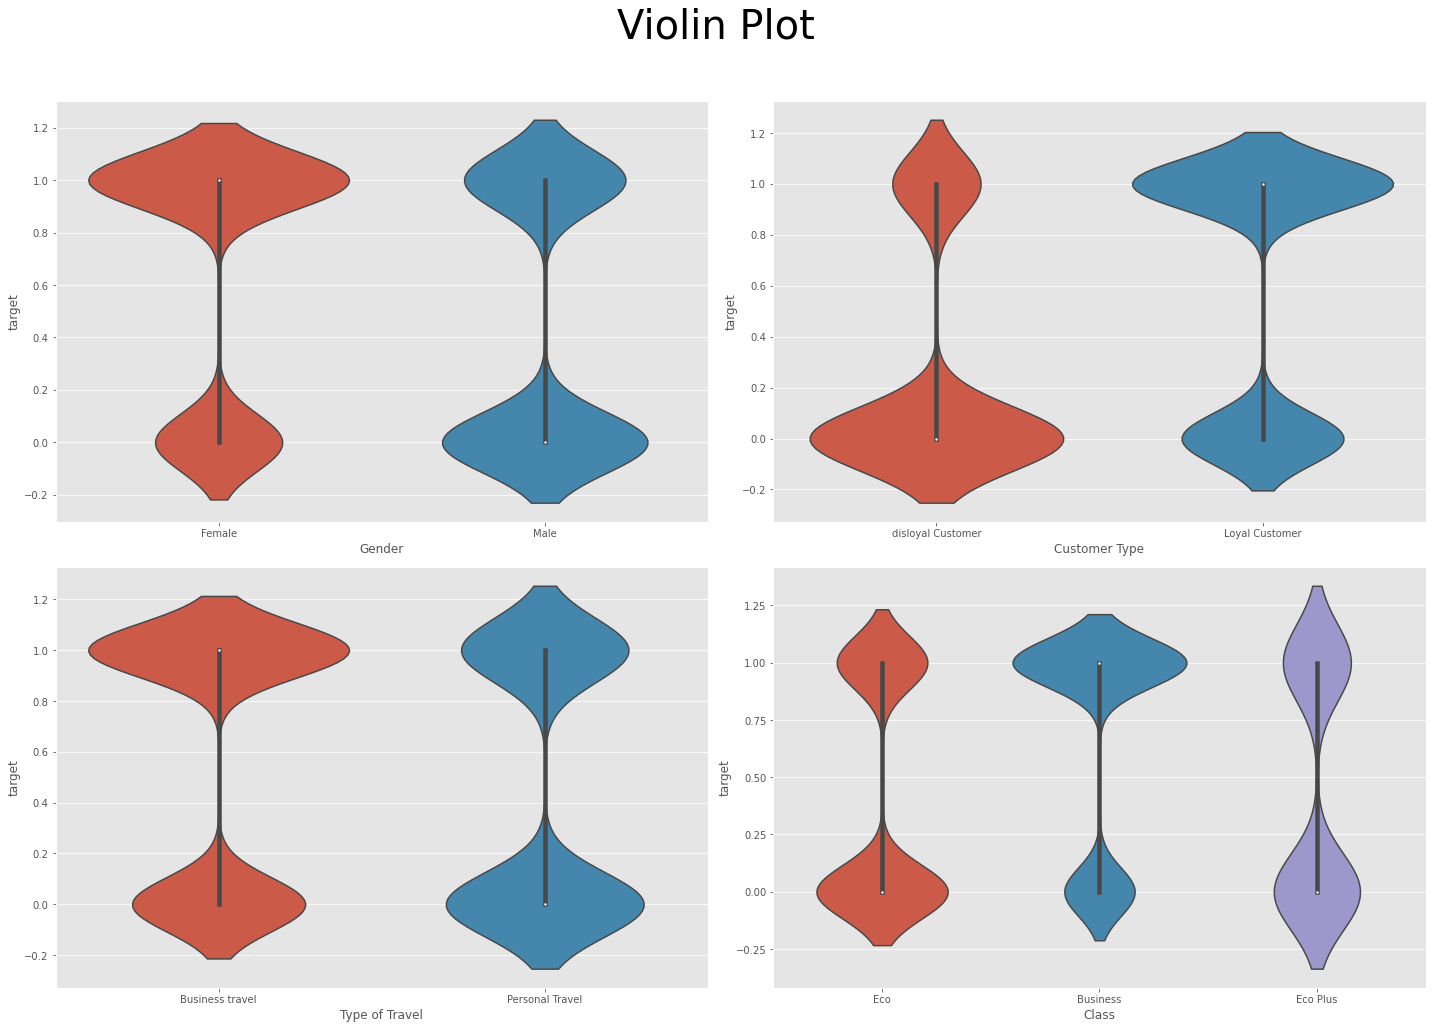

In [ ]:
# 타겟 설정
target = "target"
# 범주형 데이터 분리
categorical_feature = data.columns[data.dtypes=='object']

plt.figure(figsize=(20,15))
plt.suptitle("Violin Plot", fontsize=40)

# id는 제외하고 시각화합니다.
for i in range(len(categorical_feature)):
    plt.subplot(2,2,i+1)
    plt.xlabel(categorical_feature[i])
    plt.ylabel(target)
    sns.violinplot(x= data[categorical_feature[i]], y= data[target])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

`target`은 0과 1로 이루어져 있습니다. y축의 0부분과 1부분을 집중해서 봅시다.  
`gender`같은 경우 1을 준 성별은 여성이 많고 0을 준 성별은 남성이 많습니다.  
`Customer Type` 같은 경우 disloyal과 loyal에 따라 target값이 굉장히 차이나는 것을 볼 수 있습니다. 중요한 특징입니다.  


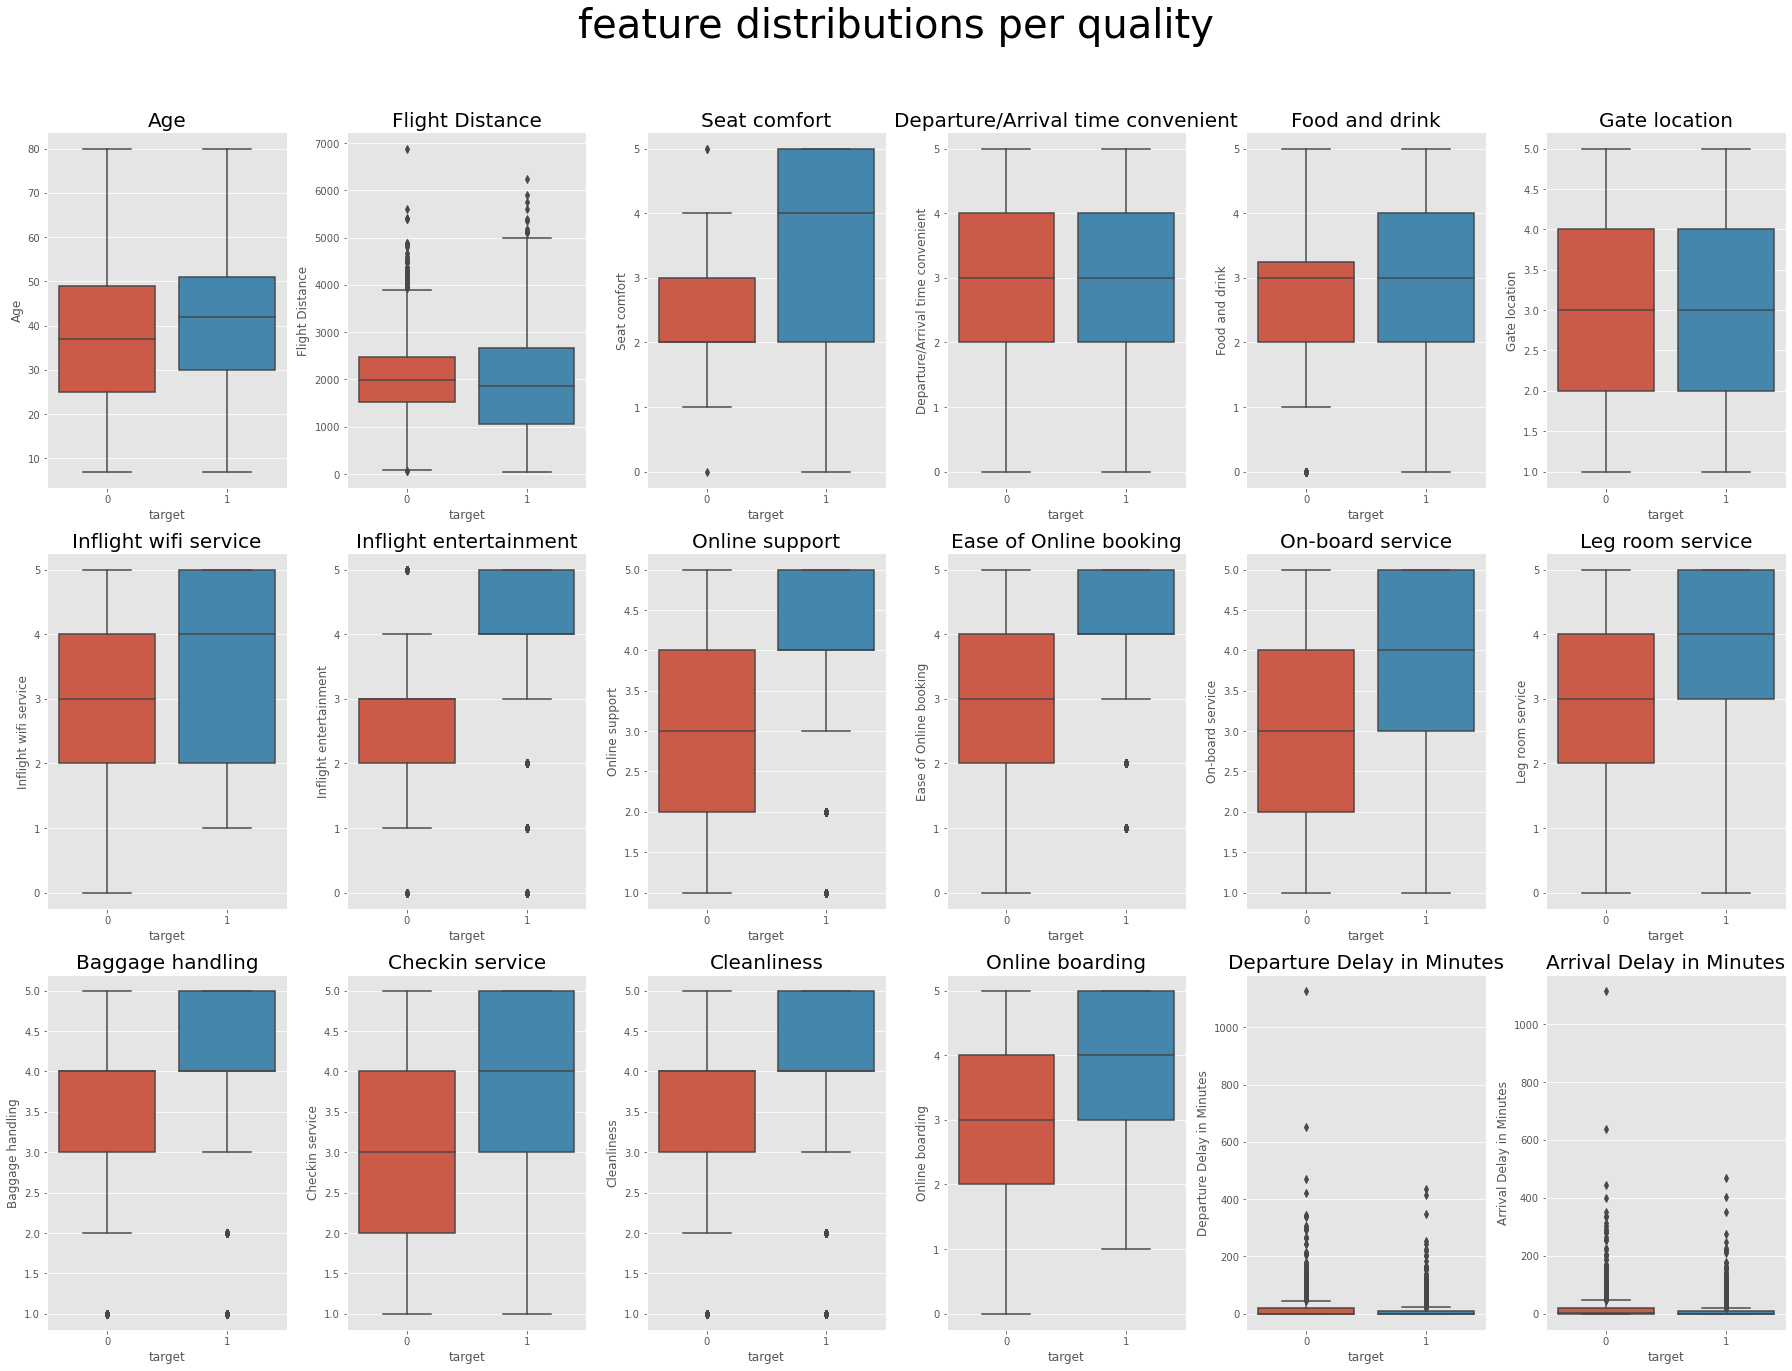

In [ ]:
# 수치형 데이터 분리
numeric_feature = data.columns[(data.dtypes=='int64') | (data.dtypes=='float')]
num_data = data[numeric_feature]

# 박스플롯
fig, axes = plt.subplots(3, 6, figsize=(25, 20))

fig.suptitle('feature distributions per quality', fontsize= 40)
for ax, col in zip(axes.flat, num_data.columns[:-1]):
    sns.boxplot(x= 'target', y= col, ax=ax, data=num_data)
    ax.set_title(col, fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

박스들이 중간에 있을 수록, 이상치가 없을 수록 골고루 분포되어있는 것으로 해석할 수 있습니다. 즉, target이 0이던 1이던 골고루 있다는 것은 그렇게 중요한 특징이 아니라는 것이죠. age,  Departure/Arrival time convenient, Gate location 등등이 별 연관이 없어보입니다.
상관계수로 확인해 보겠습니다.

## 상관계수 확인하기

### 범주형 데이터 숫자화

In [ ]:
corr_df = data.copy()
corr_df[corr_df.columns[corr_df.dtypes=='O']] = corr_df[corr_df.columns[corr_df.dtypes=='O']].astype(str).apply(LabelEncoder().fit_transform)

### heatmap을 활용하여 시각화

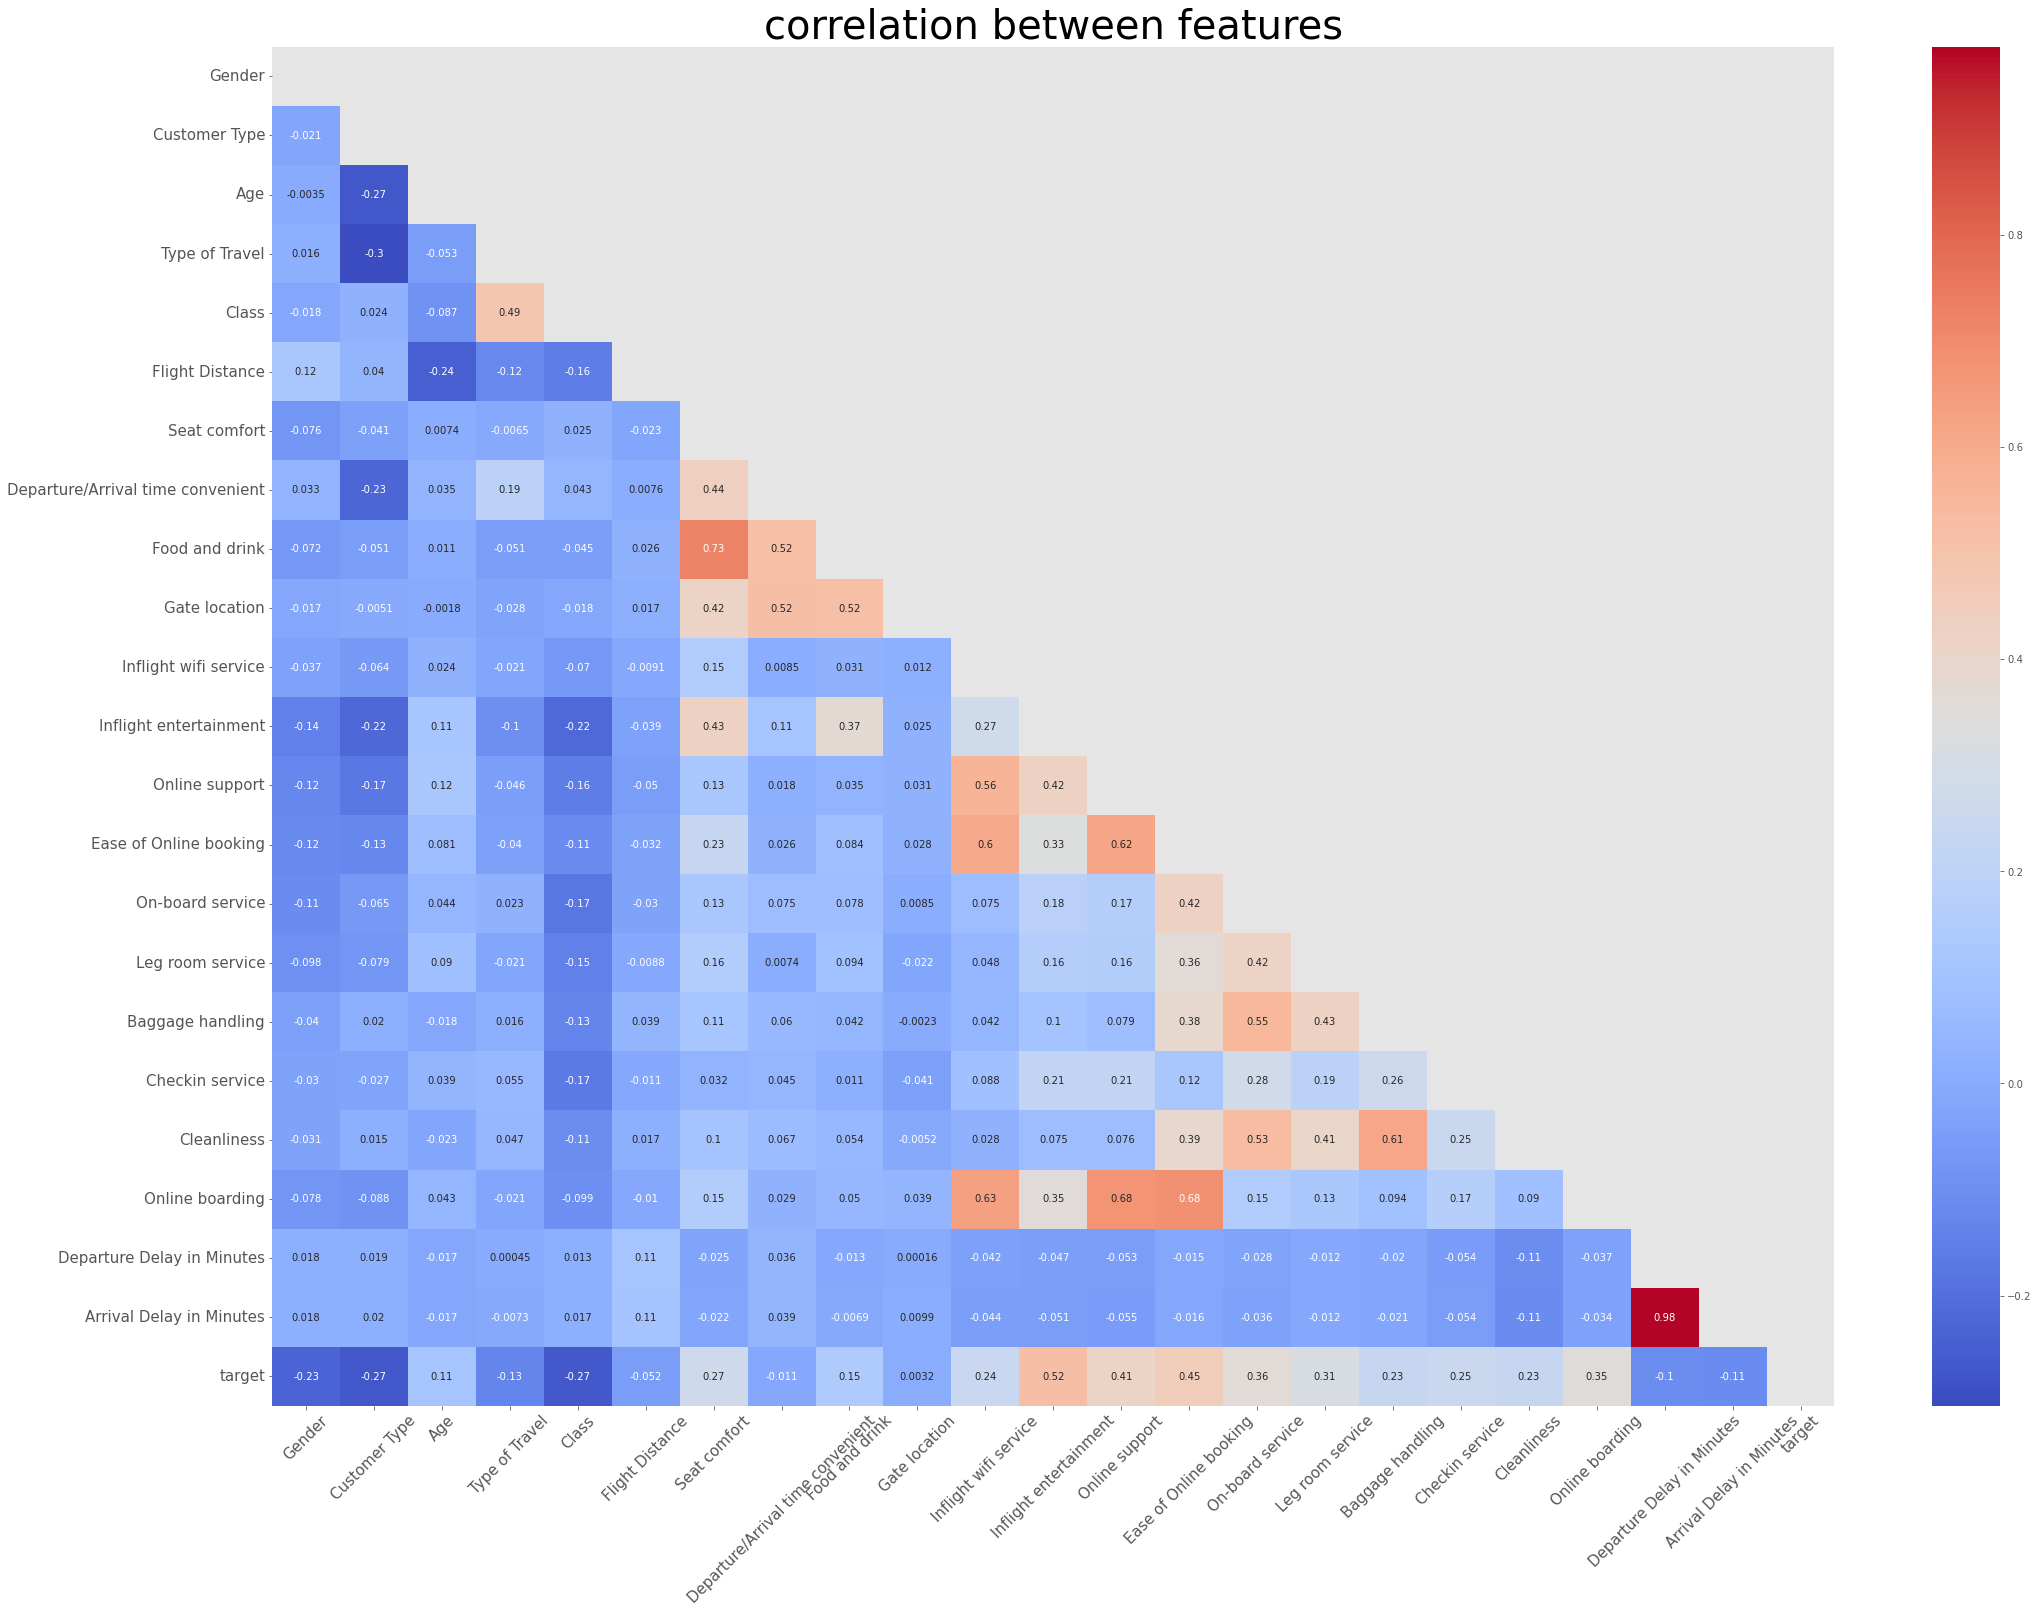

In [ ]:
plt.figure(figsize=(35,25))

heat_table = corr_df.corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)] = True
heatmap_ax = sns.heatmap(heat_table, annot=True, mask = mask, cmap='coolwarm')
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('correlation between features', fontsize=40)
plt.show()

상관계수의 값이 낮다고해서 상관계수가 안좋은게 아니라 절대값을 봐야합니다. 즉, 남색에 가까운게 안좋은게 아니라  
0에 가까운 Departure Delay in Minutes & Gate location 의 색이 상관계수가 낮은 것이라고 보면 됩니다.  
target을 기준으로 확인했을 때, 위에서 본 대로 age,  Departure/Arrival time convenient, Gate location의 상관계수가 낮은것을 확인 할 수 있습니다.  
반대로 Inflight entertainment와 Online support, Ease of Online booking 등등이 높은 상관계수를 보입니다.

### 추가+)Depature Delay in Minutes & Arrival Delay in Minuits 에 대하여
_(관련 피드백을 제공해 주신 `dong_ho` 님께 감사합니다!)_
먼저 출발 시간이 지연되면 당연히 도착시간도 지연됩니다. 근데 이 특징을 둘 다 가지고 있습니다.  
상관계수를 한 번 볼까요? 0.98로 매우 높은 상관관계를 가집니다. 과연 좋은 값일까요?  
관련 키워드는 `다중 공선성`입니다. 독립변수 즉, target이 아닌 특징들에 대하여 서로 독립적인 관계여야 합니다.  
하지만 위의 두 특징은 서로 독립적인 관계가 아니고 거의 하나로 움직이게 되는데 주로 상관계수가 0.7이상일 때 다중 공선성이 나타난다고 합니다.

0.7이상의 특징 쌍이 하나 더 보입니다. 'Food and drink' & 'Seat confort' 이네요. 좌석의 편리성과 음식 관계는 아무래도 비싼 좌석일 수록 자리가 편하고 이에따라 음식도 잘 나오므로 높게 나타난 것으로 추정됩니다.

이 다중 공선성의 처리방법중 가장 간단한 방법은 둘 중 한 특징을 제거하는 것입니다. 저는 2개의 쌍 중 target과의 상관계수가 낮은 특징을 제거해보겠습니다. 

1. Depature Delay in Minutes & Arrival Delay in Minuits (target과의 상관관계: 0.1 / 0.11)
- Depature Delay in Minutes 제거 (0.1)

2. Food and drink' & 'Seat confort ( target과의 상관관계: 0.15 / 0.27)
- Food and drink 제거 ( 0.15 )


In [ ]:
data.drop('Departure Delay in Minutes', axis = 1, inplace = True)
data.drop('Food and drink', axis = 1, inplace = True)
test.drop('Departure Delay in Minutes', axis = 1, inplace = True)
test.drop('Food and drink', axis = 1, inplace = True)

### 이상치 확인
boxplot을 이용하여 이상치들을 확인해보겠습니다.

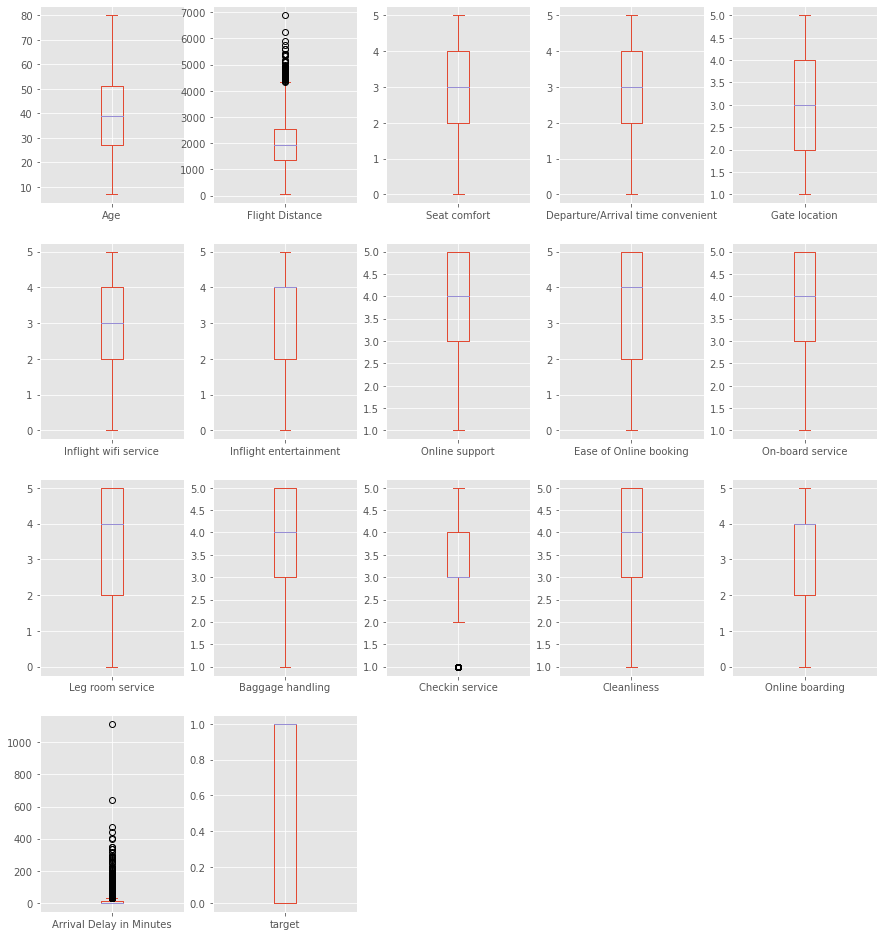

In [ ]:
data.plot(kind='box', subplots=True, layout=(5, 5), figsize=(15, 21))
plt.show()       

출발/도착 지연시간과 비행시간에 대해서 이상치가 매우 많습니다.  
~~아직 지식이 부족한데 개인적인 생각으로 출발/도착 지연시간같은 경우 이상치이더라도 지연이 크게될 수록 만족도가 당연히 하락하는데, 이상치를 처리하는게 맞는지를 잘 모르겠어서 처리는 일단 보류하겠습니다. 댓글로 피드백 주시면 감사하겠습니다!~~

이상치는 항상 제거하는게 성능에 좋겠습니다. 이상치의 인덱스를 추출하겠습니다.


In [ ]:
def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    # 넘파이의 값을 퍼센트로 표시해주는 함수

    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    
    return np.where((data > upper_bound) | (data < lower_bound))

In [ ]:
ArrivalDelay_index_data = outliers_iqr(data['Arrival Delay in Minutes'])[0]
FlightDistance_index_data = outliers_iqr(data['Flight Distance'])[0]
GarageArea_index_data = outliers_iqr(data['Checkin service'])[0]

In [ ]:
ArrivalDelay_index_data

array([   6,   23,   30,   35,   36,   51,   57,   59,   62,   66,   78,
         82,   85,   92,  116,  134,  137,  151,  160,  162,  175,  180,
        198,  202,  206,  214,  245,  255,  258,  279,  283,  285,  290,
        292,  303,  309,  315,  325,  335,  340,  341,  349,  359,  368,
        373,  375,  377,  385,  391,  394,  416,  428,  429,  435,  454,
        457,  472,  483,  484,  490,  510,  511,  517,  522,  537,  539,
        573,  575,  587,  592,  599,  604,  620,  621,  623,  627,  638,
        641,  650,  652,  653,  670,  672,  676,  693,  695,  696,  703,
        707,  715,  721,  723,  737,  752,  763,  766,  773,  774,  783,
        792,  797,  798,  799,  809,  810,  824,  837,  846,  852,  858,
        862,  869,  883,  884,  895,  904,  906,  912,  923,  937,  947,
        948,  949,  962,  968,  978,  983,  987,  993, 1001, 1002, 1013,
       1014, 1020, 1027, 1031, 1034, 1044, 1065, 1068, 1069, 1073, 1074,
       1098, 1103, 1116, 1122, 1140, 1151, 1152, 11

행 자체를 삭제하려고 보니 이상치가 포함된 행이 너무 많아 학습에 지장이 생길 것 같습니다('Arrival Delay in Minutes': 405개). 제거가아닌 평균값으로 대치하도록 하겠습니다.
이상치 인덱스에 대해 값을 대치하는 좋은 피드백을 제시해주신 _**유재성 KADE**_ 님께 감사의 말씀 드립니다!

In [ ]:
data.loc[ArrivalDelay_index_data, 'Arrival Delay in Minutes'] = data['Arrival Delay in Minutes'].mean()
data.loc[FlightDistance_index_data, 'Flight Distance'] = data['Flight Distance'].mean()
data.loc[GarageArea_index_data, 'Checkin service'] = data['Checkin service'].mean()

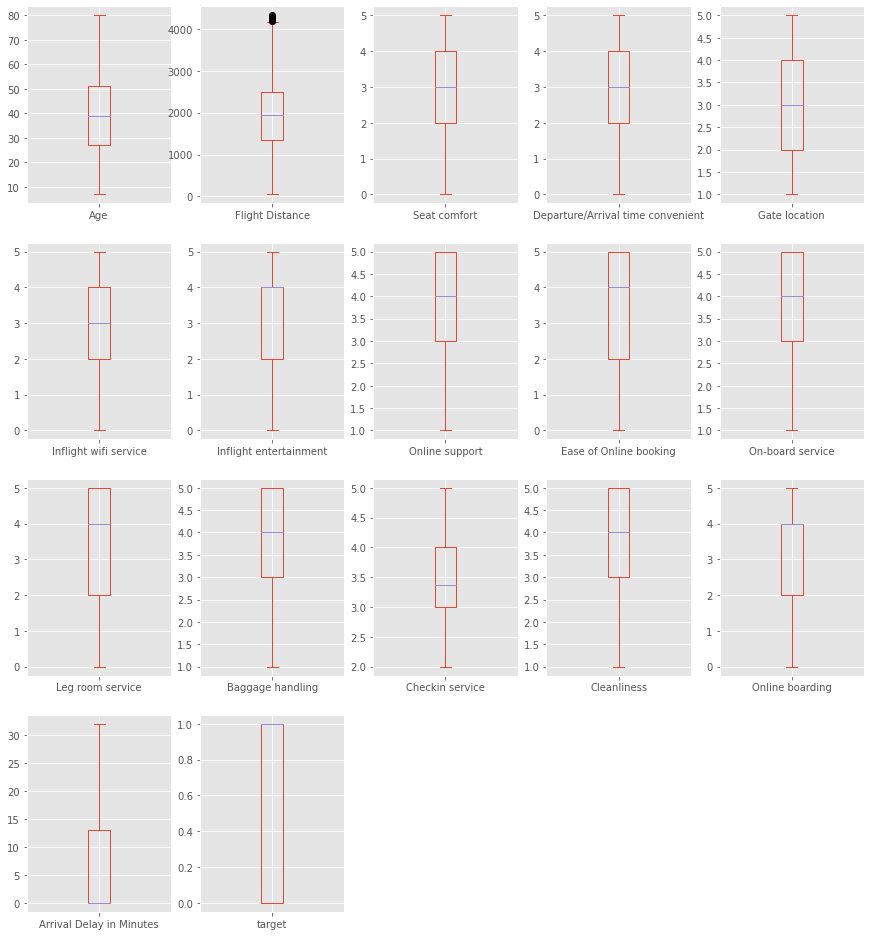

In [ ]:
data.plot(kind='box', subplots=True, layout=(5, 5), figsize=(15, 21))
plt.show()       

이상치가 잘 제거된 모습입니다. 마찬가디로 테스트 셋에 대해서도 적용합니다.

In [ ]:
ArrivalDelay_index_test = outliers_iqr(test['Arrival Delay in Minutes'])[0]
FlightDistance_index_test = outliers_iqr(test['Flight Distance'])[0]
GarageArea_index_test = outliers_iqr(test['Checkin service'])[0]

test.loc[ArrivalDelay_index_test, 'Arrival Delay in Minutes'] = test['Arrival Delay in Minutes'].mean()
test.loc[FlightDistance_index_test, 'Flight Distance'] = test['Flight Distance'].mean()
test.loc[GarageArea_index_test, 'Checkin service'] = test['Checkin service'].mean()

# 모델 학습
이제 모델을 학습시켜봅니다. 학습 후 스코어를 확인하고 스케일링을 적용해보며 결과를 비교해봅니다

In [ ]:
# 여러 모델 비교
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

### 평가 척도

In [ ]:
import numpy as np

def ACCURACY(true, pred):   
    score = np.mean(true==pred)
    return score

## K-Fold
K-Fold는 train셋 안에서(여기서는 data) train셋과 validation셋을 일정 비율로 번갈아 담당하여 스코어를 측정하여 평균값을 내놓을 수 있습니다.
이는 과적합결과를 방지해주며 보다 신뢰도 있는 스코어를 확인할 수 있습니다.

In [ ]:
def kfold(model, train, scale = False):
    cv_accuracy = []
    cv = StratifiedKFold(n_splits=5)
    
    n_iter = 0
    
    for t, v in cv.split(train, train['target']):
        
        train_cv = train.iloc[t] # 훈련용
        val_cv = train.iloc[v] # 검증용 분리

        train_X = train_cv.drop('target', axis=1)
        train_y = train_cv['target']

        val_X = val_cv.drop('target', axis=1)
        val_y = val_cv['target']
            
        model.fit(train_X, train_y)
        score = ACCURACY(val_y, model.predict(val_X))
        
        cv_accuracy.append(score)
        n_iter += 1
    return np.mean(cv_accuracy)

In [ ]:
models = [
    KNeighborsClassifier(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=20, n_estimators=300),
    GradientBoostingClassifier(),
    XGBClassifier(eval_metric = 'logloss', \
                              max_depth = 5, \
                              min_child_weight = 3, \
                               gamma = 3, \
                               colsample_bytree = 0.5, \
                               n_estimators=700),
    LGBMClassifier(n_estimators=600, max_bin=400, num_leaves=24),
    CatBoostClassifier(silent=True, depth=6, l2_leaf_reg=7, learning_rate=0.1, n_estimators=500),
    ExtraTreesClassifier(max_depth=25, n_estimators=320)
]

print('스케일링 적용 전')
for model in models:
    print(f'{type(model).__name__} score: {kfold(model, data)}')

스케일링 적용 전
KNeighborsClassifier score: 0.6056666666666667
LogisticRegression score: 0.8119999999999999
DecisionTreeClassifier score: 0.8776666666666667
RandomForestClassifier score: 0.8943333333333333
GradientBoostingClassifier score: 0.9123333333333333
[12:46:16] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:46:17] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please ope

# 모델 튜닝
이제 최종적으로 적용하기 전에 모델튜닝을 진행합니다. gridSerchCV를 통해 최적의 하이퍼파라메타를 찾아보겠습니다.

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

## RandomForest

In [ ]:
params = { 'n_estimators' : [10, 100, 1000],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

In [ ]:
train = data.drop('target', axis=1)
target = data['target']

model_RFC = RandomForestClassifier()
grid_cv_RFC = GridSearchCV(model_RFC, param_grid = params, cv=5, n_jobs = -1)
grid_cv_RFC.fit(train, target) # train과 target은 위에 train_test_split하기 전에 있었음
print('최적 하이퍼 파라미터: ', grid_cv_RFC.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv_RFC.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}
최고 예측 정확도: 0.8983


## 모델 앙상블
원본데이터에서 성능이 좋게나온 3가지의 모델 RandomForestClassifier, XGBClassifier, LGBMClassifier를 사용해보겠습니다.  
그리고 앙상블과 원본의 정확도를 비교해보겠습니다

크게 차이나지는 않지만 과반수기법인 HardVoting기법을 사용하여 앙상블을 진행했습니다.


## XGBClassifier  
참고: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=gustn3964&logNo=221431933811

In [ ]:
model_XGB = XGBClassifier(eval_metric='logloss', silent = True)

param_grid={'booster' :['gbtree'],
                 'silent':[True],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,2,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50],
                 'objective':['binary:logistic'],
                 'random_state':[2]}

grid_cv_XGB=GridSearchCV(model_XGB, param_grid=param_grid, cv=5 , n_jobs=-1)
grid_cv_XGB.fit(train, target)
print('최적 하이퍼 파라미터: ', grid_cv_XGB.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv_XGB.best_score_))

[12:52:20] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 하이퍼 파라미터:  {'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 50, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 2, 'silent': True}
최고 예측 정확도: 0.9353


## LGBMClassifier  
참고: https://www.kaggle.com/bitit1994/parameter-grid-search-lgbm-with-scikit-learn

In [ ]:
model_LGBM = LGBMClassifier()

gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [100, 500, 1000],
    'num_leaves': [12, 16, 20], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[300, 600], # large max_bin helps improve accuracy but might slow down training progress
    }

grid_cv_LGBM = GridSearchCV(model_LGBM, param_grid=gridParams, cv=3 , n_jobs=-1)
grid_cv_LGBM.fit(train, target)
print('최적 하이퍼 파라미터: ', grid_cv_LGBM.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv_LGBM.best_score_))

최적 하이퍼 파라미터:  {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_bin': 300, 'n_estimators': 1000, 'num_leaves': 20, 'objective': 'binary'}
최고 예측 정확도: 0.9107


## CatBoostClassifier
참고 : https://catboost.ai/en/docs/concepts/python-reference_catboost_grid_search

In [ ]:
model_CAT = CatBoostClassifier(silent = True)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_cv_CAT = GridSearchCV(model_CAT, param_grid=grid, cv=3 , n_jobs=-1)
grid_cv_CAT.fit(train, target)
print('최적 하이퍼 파라미터: ', grid_cv_CAT.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv_CAT.best_score_))



최적 하이퍼 파라미터:  {'depth': 6, 'l2_leaf_reg': 9, 'learning_rate': 0.1}
최고 예측 정확도: 0.9417


# 제출

soft보팅 기법을 사용하여 4가지의 모델(XGB + LGBM + CAT + EXTRA)을 앙상블합니다.

In [ ]:
train = data.drop('target', axis=1)
target = data['target']

best_model_XGB = XGBClassifier(eval_metric = 'logloss', \
                              silent = True, \
                              max_depth = 5, \
                              min_child_weight = 3, \
                               gamma = 3, \
                               colsample_bytree = 0.5, \
                               n_estimators=700)
best_model_LGBM = LGBMClassifier(n_estimators=600, max_bin=400, num_leaves=24)
best_model_CAT = CatBoostClassifier(silent=True, depth=6, l2_leaf_reg=7, learning_rate=0.1, n_estimators=500)
best_model_EXTRA = ExtraTreesClassifier(max_depth=25, n_estimators=320)


from sklearn.ensemble import VotingClassifier
softVoting_model = VotingClassifier(estimators=[('XGB', best_model_XGB), ('LGBM', best_model_LGBM), ('CAT', best_model_CAT), ('EXTRA', best_model_EXTRA)], voting='soft') 
softVoting_model.fit(train, target)


[12:57:21] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




VotingClassifier(estimators=[('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            enable_categorical=False,
                                            eval_metric='logloss', gamma=3,
                                            gpu_id=None, importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=5,
                                            min_child_weight=3, missing=nan,
                                            monoto...
                                            reg_alpha=None, reg_lambda=None,
                                      

(array([ 914.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1086.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

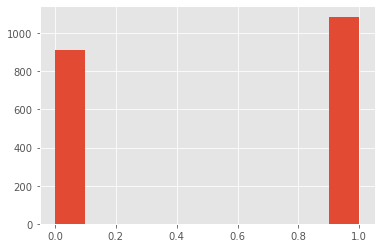

In [ ]:
soft_pred = softVoting_model.predict(test)
plt.hist(soft_pred)

In [ ]:
submission = pd.read_csv('D:/Dacon/airline_satisfied_score_predict/sample_submission.csv')
submission

,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
1995,1996,0
1996,1997,0
1997,1998,0
1998,1999,0


In [ ]:
submission['target'] = soft_pred
submission

,id,target
0,1,1
1,2,0
2,3,1
3,4,1
4,5,1
...,...,...
1995,1996,0
1996,1997,1
1997,1998,0
1998,1999,1


In [ ]:
submission.to_csv('D:/Dacon/airline_satisfied_score_predict/submission_XGB_LGBM_CAT_EXTRA_soft_2.csv', index=False)

# 제출 결과

0.939의 스코어를 기록했습니다. (22/02/14)
추가적인 전처리를 진행하여 스코어를 높여보겠습니다!